In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.spatial.distance import cdist

symbolic = '[<>?,%()]|nan|NAN|NaN|na|NA'

In [2]:
def pca(data, n_components, threshold=0.95 ):
    # Step 1: Standardize the data (zero mean and unit variance)
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    standardized_data = (data - mean) / std

    # Step 2: Compute the covariance matrix
    covariance_matrix = np.cov(standardized_data, rowvar=False)

    # Step 3: Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Step 4: Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    total_variance = np.sum(eigenvalues)
    explained_variance_ratio = eigenvalues / total_variance
    cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

    # Step 5: Select the top n_components eigenvectors
    top_n = 0
    for index, sum_variance in enumerate(cumulative_explained_variance_ratio):
        # print(index, sum_variance)
        top_n = index + 1
        if sum_variance >= 0.95:
            break
    print(f"top_n components is {top_n}")
    top_components = eigenvectors[:, :top_n]

    # Step 6: Project the data onto the principal components
    projected_data = np.dot(standardized_data, top_components)

    return projected_data, eigenvalues[:n_components], top_components, explained_variance_ratio, cumulative_explained_variance_ratio



In [3]:
def preprocessing(data):
    columns = data.columns
    for column in columns:
        new_values = []
        for cell in data[column]:
            new_value = str(cell)
            new_value = re.sub(symbolic, '', new_value)       # del symbolic
            new_value = new_value.strip()                     # del space
            if new_value == '':
                new_value = None
            elif new_value.find(' kha') >= 0:
                new_value = new_value.replace(' kha', '')
                new_value = float(new_value) * 1000.0
            elif new_value.find(' Mha') >= 0:
                new_value = new_value.replace(' Mha', '')
                new_value = float(new_value) * 1000000.0
            elif new_value.find(' ha') >= 0:
                new_value = new_value.replace(' ha', '')
                new_value = float(new_value)
            else:
                # print(column, new_value)
                new_value = float(new_value)
            # print(new_value)
            new_values.append(new_value)
        data[column] = new_values
    for column in data.columns:
        mean_value = data[column].astype(float).mean()  # compute mean
        data[column] = data[column].fillna(mean_value)  
        # data[column] = data[column].replace(to_replace='NAN', value='0')   # NAN(string)
        # data[column] = data[column].astype(str).astype(float)

    # data = np.nan_to_num(data, nan=0, posinf=0, neginf=0)                  # NAN(Numpy)
    return data

In [4]:
file_path = r'C:\Users\HP\Desktop\Butterfly project\butterfly-data.csv'
data = pd.read_csv(file_path, delimiter=',', quotechar='"', engine='python')

data.columns = data.columns.str.strip().str.replace(r'(?<=[a-zA-Z])(?=[A-Z])', ' ', regex=True)


print("Columns in DataFrame:", data.columns)


numerical_columns = [
    'the average Annual Relative Humidity',
    'plant species',
    'area',
    'latitude',
    'Metres from Sea Level',
    '% Of landmass used for agriculture',
    'Amount of forest lost 2023',
    '% of urbanisation',
    'The population density [per Km2]'
]


Columns in DataFrame: Index(['number', 'Country', 'the average Annual Relative Humidity',
       'plant species', 'Köppen-Geiger Climate Classification',
       'Number of species', 'area', 'latitude', 'island',
       'Metres from Sea Level', '% Of landmass used for agriculture',
       'Amount of forest lost 2023', '% of urbanisation',
       'The population density [per Km2]'],
      dtype='object')


In [5]:
countries = data['Country']
num_species = data['Number of species']
new_data = data[numerical_columns]
data_array = preprocessing(new_data)


# Perform PCA
max_num_features = min(data.shape) - 1    
projected_data, explained_variance, components, expected_variance, cumu_variances = pca(data_array, n_components=max_num_features)

# Print results
print("Projected Data:")
print(projected_data)
print("\nExplained Variance:")
print(f"\nNumber of Selected Principal Components: {components.shape[1]}")
print()


top_n components is 8
Projected Data:
[[-5.51243181e-01  5.79512286e-02  7.98468831e-01 -1.91637873e-01
   7.25838483e-01  3.54761658e-01  3.87196145e-01 -4.83204007e-01]
 [-1.94855748e+00 -2.11953023e-01 -9.70522748e-01 -2.40139335e-01
  -6.29335164e-01  4.16967755e-01  3.42840060e-01  4.03262633e-01]
 [-8.84599212e-01  3.18236417e-01 -3.77297895e-02 -2.90903407e-01
  -1.90797786e-01  1.90423594e-01  8.91580255e-02  1.84075646e-01]
 [ 3.13883809e-02 -2.98608934e-01  4.48862944e-01  1.17259408e+00
   2.13150612e+00  1.25529644e-01 -1.31924319e+00  4.06658852e-01]
 [-1.02956310e+00  4.17896066e-01 -1.49728695e-01 -1.86435165e-01
  -1.13713698e-02  2.45859723e-01  4.95132738e-02 -1.81674789e-01]
 [-1.75136745e+00  9.19257049e-01 -1.13258672e+00 -5.50412787e-01
  -1.10415554e+00  9.18939333e-02  7.69887164e-02 -6.46530585e-02]
 [-1.61749117e+00 -1.26025538e-01 -2.24485276e-01 -1.90720186e-01
   1.33343188e+00 -7.23173285e-04  4.87319229e-01 -1.95923893e-01]
 [-1.82916860e+00 -9.20175038e-

C:\Users\HP\AppData\Local\Temp\ipykernel_21272\4012018193.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = new_values
C:\Users\HP\AppData\Local\Temp\ipykernel_21272\4012018193.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = data[column].fillna(mean_value)


In [6]:
# Show Explained Variance
for i, variance in enumerate(expected_variance):
    print(f"PC{i+1}: {variance * 100:.2f}% explained variance")

# Show Cumulative Explained Variance
print("\nCumulative Explained Variance:")
for i, cum_variance in enumerate(cumu_variances):
    print(f"PC{i+1}: {cum_variance * 100:.2f}% cumulative variance")

PC1: 27.28% explained variance
PC2: 17.31% explained variance
PC3: 16.39% explained variance
PC4: 12.44% explained variance
PC5: 8.50% explained variance
PC6: 7.19% explained variance
PC7: 5.78% explained variance
PC8: 3.74% explained variance
PC9: 1.38% explained variance

Cumulative Explained Variance:
PC1: 27.28% cumulative variance
PC2: 44.59% cumulative variance
PC3: 60.98% cumulative variance
PC4: 73.42% cumulative variance
PC5: 81.92% cumulative variance
PC6: 89.11% cumulative variance
PC7: 94.88% cumulative variance
PC8: 98.62% cumulative variance
PC9: 100.00% cumulative variance


In [7]:
# features for PC1 and PC2
pc1_weights = components[:, 0]  
pc2_weights = components[:, 1] 
feature_weights = pd.DataFrame({
    'Feature': new_data.columns, 
    'PC1 Weight': pc1_weights,   
    'PC2 Weight': pc2_weights    
})

# Sort features by their weights in PC1 
top_features_pc1 = feature_weights.sort_values(by='PC1 Weight', ascending=False)

# Sort features by their weights in PC2
top_features_pc2 = feature_weights.sort_values(by='PC2 Weight', ascending=False)

print("Top Features in PC1:")
print(top_features_pc1.head())

print("\nTop Features in PC2:")
print(top_features_pc2.head())


Top Features in PC1:
                              Feature  PC1 Weight  PC2 Weight
1                       plant species    0.520382   -0.143603
2                                area    0.361970    0.179266
6          Amount of forest lost 2023    0.292276   -0.437552
4               Metres from Sea Level    0.215977   -0.122584
5  % Of landmass used for agriculture    0.096571    0.550726

Top Features in PC2:
                              Feature  PC1 Weight  PC2 Weight
5  % Of landmass used for agriculture    0.096571    0.550726
3                            latitude   -0.452003    0.199185
2                                area    0.361970    0.179266
4               Metres from Sea Level    0.215977   -0.122584
1                       plant species    0.520382   -0.143603


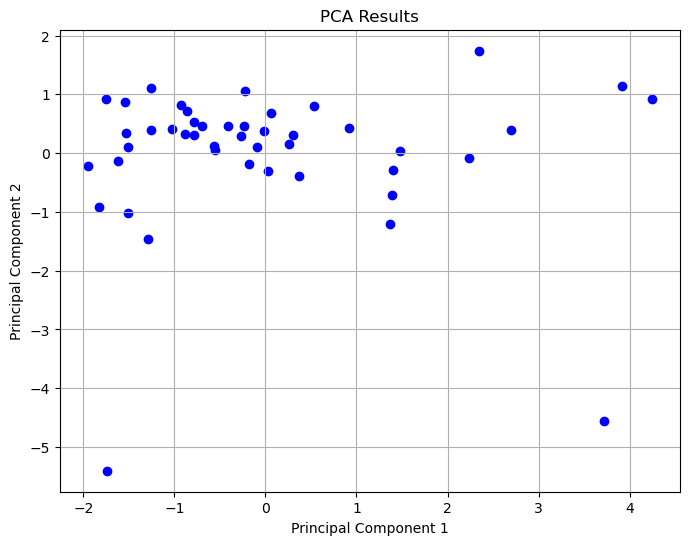

In [8]:
# Visualize the first 2 projected data
plt.figure(figsize=(8, 6))
plt.scatter(projected_data[:, 0], projected_data[:, 1], color="blue")
plt.title("PCA Results")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.show()

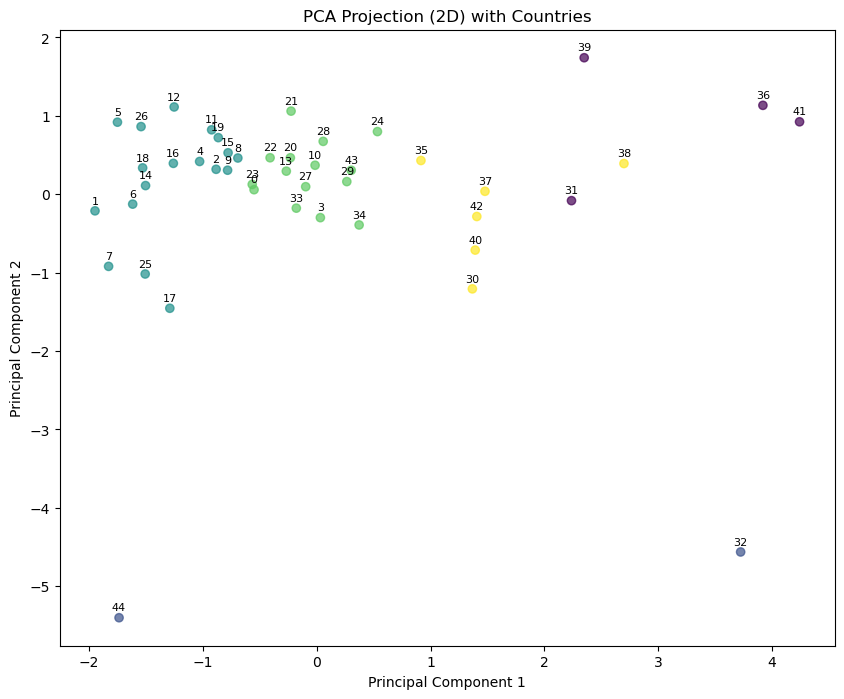

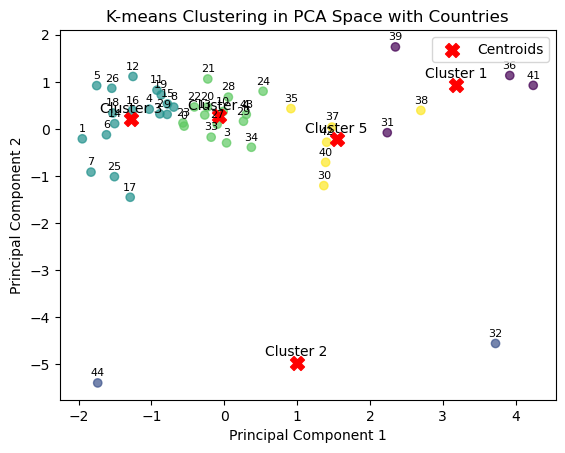

In [9]:
reduced_data = projected_data
numbers = range(len(reduced_data))
num_clusters = 5
np.random.seed(42)
initial_centroids = reduced_data[np.random.choice(reduced_data.shape[0], num_clusters, replace=False)]
centroids = initial_centroids.copy()

for iteration in range(100):
    # Assign clusters
    distances = cdist(reduced_data, centroids, metric='euclidean')
    cluster_assignments = np.argmin(distances, axis=1)
    
    # Update centroids
    new_centroids = np.array([reduced_data[cluster_assignments == k].mean(axis=0) for k in range(num_clusters)])
    
    if np.allclose(centroids, new_centroids):
        break
    centroids = new_centroids

plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_assignments, alpha=0.7)

# Create a legend for the clusters
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection (2D) with Countries')

# Annotate points with country names
for i, number in enumerate(numbers):
    plt.annotate(number, (reduced_data[i, 0], reduced_data[i, 1]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

# Show the plot
plt.show()

# If you want to add country info in the K-means plot
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_assignments, alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], color='red', marker='X', s=100, label='Centroids')

# Annotate centroids with cluster numbers
for i, centroid in enumerate(centroids):
    plt.annotate(f'Cluster {i+1}', (centroid[0], centroid[1]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10)

# Annotate points with country names
for i, number in enumerate(numbers):
    plt.annotate(number, (reduced_data[i, 0], reduced_data[i, 1]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering in PCA Space with Countries')
plt.legend()
plt.show()


In [10]:
# After performing K-means clustering, group country names and their species count by their assigned clusters
country_species_groups = {i: [] for i in range(num_clusters)}

# Assign country names and their number of species to their respective clusters
for i, cluster_id in enumerate(cluster_assignments):
    country_species_groups[cluster_id].append((countries.iloc[i], num_species.iloc[i]))

# Print the list of countries and their associated number of species in each cluster
for cluster_id, country_species_list in country_species_groups.items():
    print(f"Cluster {cluster_id + 1}:")
    for country, species_count in country_species_list:
        print(f"{country} - Number of species: {species_count}")
    print()  # Blank line between clusters


Cluster 1:
Mexico State - Number of species: 325
Australia - Number of species: 398
South Africa - Number of species: 797
India - Number of species: 1163

Cluster 2:
Federal District, Brazil - Number of species: 839
Hong Kong - Number of species: 236

Cluster 3:
Belgium - Number of species: 88
Bulgaria - Number of species: 211
Czech Republic - Number of species: 140
Denmark - Number of species: 63
Estonia - Number of species: 98
Finland - Number of species: 110
France - Number of species: 244
Germany - Number of species: 178
Hungary - Number of species: 152
Ireland - Number of species: 30
Latvia - Number of species: 105
Lithuania - Number of species: 114
Luxembourg - Number of species: 78
Malta - Number of species: 18
Netherlands - Number of species: 55
Poland - Number of species: 147
Sweden - Number of species: 108
UK - Number of species: 55

Cluster 4:
Austria - Number of species: 197
Cyprus - Number of species: 48
Greece - Number of species: 230
Italy - Number of species: 264
Portug